In [ ]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset_servo_positioning_system import ServoPositioningSystemDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [230]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [231]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [232]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256


# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [233]:
# Create out dir
out_dir = Path(out_dir)
#exp_data = torch.load(out_dir/"ckpt_onestep_wh_medium.pt", map_location=device)
#exp_data = torch.load(out_dir/"ckpt_onestep_wh_large.pt", map_location=device)
exp_data = torch.load(out_dir/"ckpt_controller_integral_error_no_normed_no_skip_prbs.pt", map_location=device)

In [234]:
exp_data.keys()
# np.sqrt(exp_data['best_val_loss'])
# print(len(exp_data['LOSS']))
# print(len(exp_data['LOSS_VAL']))

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

In [235]:
exp_data['model_args']

{'n_layer': 12,
 'n_head': 4,
 'n_embd': 128,
 'n_y': 1,
 'n_u': 1,
 'block_size': 502,
 'bias': False,
 'dropout': 0.0}

In [236]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [237]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [238]:
# # Create data loader
# load_test_ds = False
# 
# # if load_test_ds:
# #     test_dl = torch.load('dataloader_cstr_np_normed_no_skip.pt')
# # else:
# test_ds = ServoPositioningSystemDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len, system_seed=system_seed, data_seed=data_seed, fixed_system=False)
# test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)
# batch_y, batch_u = next(iter(test_dl))

In [239]:
# plt.plot(batch_u[:,:,0].T, c='k', alpha=0.2)
# plt.ylabel('$e_{V}$')
# plt.show()

In [240]:
# with torch.no_grad():
#     batch_y_pred, loss = model(batch_u, batch_y)
#     batch_y_pred = batch_y_pred.detach().numpy()
#     batch_y = batch_y.detach().numpy()
#     batch_u = batch_u.detach().numpy()

In [241]:
# plt.subplot(211)
# plt.plot(batch_y[5,:])
# plt.plot(batch_y_pred[5,:])
# plt.subplot(212)
# plt.plot(batch_y[5,:] - batch_y_pred[5,:])

In [242]:
import pickle as pkl
with open('../data/control/test_set_prbs.pkl', 'rb') as f:
    test_set = pkl.load(f)
u_test = test_set['u_test']
x_test = test_set['x_test']
# e_v_test = test_set['e_v_test']
y_test = test_set['y_test']
data_test = test_set['data_test']

batch_u = torch.Tensor(u_test)
batch_y = torch.Tensor(y_test[:,:,0])

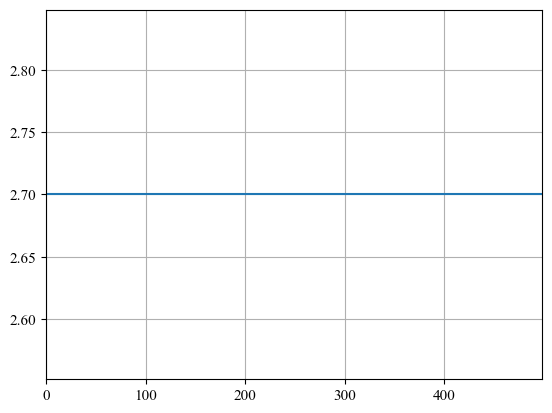

In [243]:
# reference
Ts = 0.01
t_CL = np.arange(0, 5, Ts)
r = np.zeros(t_CL.shape)
# r[t_CL < 1] = 2.7
# r[(t_CL >= 1) & (t_CL < 2)] = -2.7
# r[(t_CL >= 2) & (t_CL < 3.5)] = 5
# r[(t_CL >= 3.5) & (t_CL < 5)] = 0
r[t_CL < 5] = 2.7
r[(t_CL >= 5) & (t_CL < 10)] = 3.6
r[(t_CL >= 10) & (t_CL < 15)] = 4.1
r[(t_CL >= 15) & (t_CL < 25)] = 3.8
r[(t_CL >= 25) & (t_CL < 35)] = 2.1
r[(t_CL >= 35)] = 4.1

plt.plot(r)

In [244]:
from servo_positioning_system_chatgpt import servo_motor, simulate_servo_positioning_system
from numba import float32, float64, jit, NumbaWarning, NumbaPerformanceWarning, NumbaDeprecationWarning
import numba
from numba.typed import Dict
import time
#batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
batch_y_pred= torch.Tensor(batch_y.shape)

n_testing = 5

time_vec = []

Ts_simulation = 1e-4
e = torch.Tensor([[[]]])
u = torch.Tensor([[[]]])

x_i = np.array([1e-3, 1e-3, 1e-3])
y_i = x_i[0]
u_i = 1e-3
e_integral_i = 0

y_log = np.zeros(len(t_CL))
e_log = np.zeros(len(t_CL))
u_log = np.zeros(len(t_CL))

data = Dict()
for k, v in data_test[n_testing].items():
    data[k] = v

with torch.no_grad():
    for i in range(len(t_CL)):#batch_u.shape[0]): # for each system
        print(i)
        
        e_i = torch.Tensor([[[r[i] - y_i]]])
        e_integral_i += e_i
        e_log[i] = e_integral_i
        
        # e = e_i
        # u = torch.Tensor([[[u_i]]])
        e = torch.cat((e,e_integral_i),2)
        u = torch.cat((u,torch.Tensor([[[u_i]]])),2)
        # 
        # Controller
        pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))

        u_i = pred[:,-1,:].item()
        u_log[i] = u_i
        
        
        u_tmp = np.ones(int(Ts/Ts_simulation)) * u_i
    
        s = x_i
        
        for ii in range(len(u_tmp)):
            a = u_tmp[ii]
            # Runge-Kutta
            k1 = Ts_simulation * servo_motor(s, a, data)
            k2 = Ts_simulation * servo_motor(s + 0.5 * k1, a, data)
            s = s + k2

        x_i = s
        y_i = x_i[0]
        y_log[i] = y_i
        
        # apply the input to the system
        
        
        
    #     pred, _ = model(batch_u[i:i+1, -500:,:], batch_y[i:i+1, -500:, :])
    #     batch_y_pred[i, -500:, :] = pred
    #     
    # batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    # batch_y = batch_y.to("cpu").detach().numpy()
    # batch_u = batch_u.to("cpu").detach().numpy()
#elapsed_time = time.time() - start
#print(elapsed_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

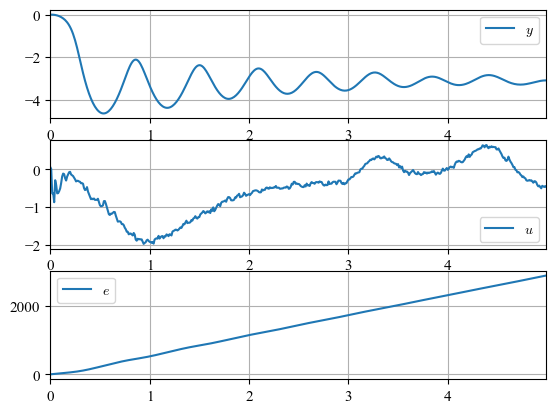

In [245]:
plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, y_log)
plt.legend(['$y$'])
plt.subplot(312)
plt.plot(t_CL, u_log)
plt.legend(['$u$'])
plt.subplot(313)
plt.plot(t_CL, e_log)
plt.legend(['$e$'])

In [17]:
batch_u.shape

torch.Size([50, 500, 1])

In [18]:
numba.typed.dict(data_test[n_testing])

AttributeError: 

In [ ]:
numba.typed.Dict

In [ ]:
Ts/Ts_simulation

In [ ]:
model(e, u)

In [ ]:
import time
#batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
batch_y_pred= torch.Tensor(batch_y.shape)

ell = 500

time_vec = []
with torch.no_grad():
    for i in range(2):#batch_u.shape[0]): # for each system
        print(i)
        for t in range(0, batch_u.shape[1]):
            #print(t)
            start = time.time()
            
            if t < ell:
                pred, _ = model(batch_u[i:i+1,:t+1,:], batch_y[i:i+1, :t+1,:])
            else:
                pred, _ = model(batch_u[i:i+1,t-ell+1:t+1,:], batch_y[i:i+1,t-ell+1:t+1,:])
            print('time:',t)
            print('shape:',pred.shape)
            time_vec.append(time.time() - start)
            
            batch_y_pred[i, t, :] = pred[:, -1, :]
            #print(pred.shape)
            #break
        #break
        #batch_y_pred[i] = pred # last sample
        #start = time.time()
        #batch_y_pred[i], _ = model(batch_u[i:i+1], batch_y[i:i+1])
        #time_vec.append(time.time() - start)
    batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    batch_y = batch_y.to("cpu").detach().numpy()
    batch_u = batch_u.to("cpu").detach().numpy()
#elapsed_time = time.time() - start
#print(elapsed_time)

In [ ]:
batch_y_pred.shape

In [ ]:
time_vec

In [ ]:
np.std(time_vec)/500 * 1000

In [ ]:
# batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
# batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k} / filter @ time k: y_{k|k}
# batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
# batch_pred_err = batch_y_target - batch_y_pred
# batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy
batch_pred_err = batch_y - batch_y_pred
# batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

In [ ]:
t = np.arange(1, batch_y.shape[1]+1)

In [ ]:
test_idx = 0
plt.plot(batch_y[test_idx,:,1], label='true')
plt.plot(batch_y_pred[test_idx,:,1], label='estimated')
#plt.xlim([200, 300])
plt.legend()
plt.show()

In [ ]:
transformer_data = {'t': t,
            'u1': u_test[:, :, 0],
            'u2': u_test[:, :, 1],
            'x1_n': x_n_test[:, :, 0],
            'x2_n': x_n_test[:, :, 1],
            'x1': x_test[:, :, 0],
            'x2': x_test[:, :, 1],
            'y1': y_test[:, :, 0],
            'y2': y_test[:, :, 1],
            'x1_hat': batch_y_pred[:, :, 0],
            'x2_hat': batch_y_pred[:, :, 1],
            'time': np.reshape(time_vec, (u_test.shape[0], -1))
            }

with open("data/transformer_prbs_data2.pkl", "wb") as f:
    pkl.dump(transformer_data, f)

In [ ]:
batch_y_pred[0, -1, :]

In [ ]:
x1_n_mean = batch_y[:,:,0].mean(axis=0)
# x1_mean = x_test[:,:,0].mean(axis=0)
x1_hat_mean = batch_y_pred[:,:,0].mean(axis=0)
x1_err_mean = np.sqrt(np.power(batch_y[:,:,0] - batch_y_pred[:,:,0], 2).mean(axis=0))
x2_n_mean = batch_y[:,:,1].mean(axis=0)
# x2_mean = x_test[:,:,1].mean(axis=0)
x2_hat_mean = batch_y_pred[:,:,1].mean(axis=0)
x2_err_mean = np.sqrt(np.power(batch_y[:,:,1] - batch_y_pred[:,:,1], 2).mean(axis=0))
# y2_mean = y_test[:,:,1].mean(axis=0)

fig = plt.figure(figsize=(5,4))

ax1 = plt.subplot(221)
# plt.plot(t, x1_mean, label='$\overline{x}_1$')
plt.plot(t, x1_n_mean, label='$\overline{x}^{\mathrm{o}}_1$')
plt.plot(t, x1_hat_mean, label='$\overline{\hat{x}}_1$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="lower right")

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(x1_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_1 - \hat{x}_1)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$')
plt.ylim([0, 10])
plt.legend()

ax3 = plt.subplot(222)
# plt.plot(t, y2_mean, label='$\overline{y}$')
# plt.plot(t, x2_mean, label='$\overline{x}_2$')
plt.plot(t, x2_n_mean, label='$\overline{x}^{\mathrm{o}}_2$')
plt.plot(t, x2_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax4 = plt.subplot(224, sharex=ax1)
plt.plot(x2_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig('transformer_2.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(10, 2.5))

idx = 31
plt.subplot(121)
plt.plot(t, batch_y[idx,:,1], 'k', label="$y$")
plt.plot(t, batch_y_pred[idx,:,1], 'b', label="$\hat y$")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(t, batch_y[idx,:,1] - batch_y_pred[idx,:,1], 'r', label="$y - \hat y$")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
#plt.xlim([0, 100]);
#plt.ylim([-3, 3]);
plt.xlabel("time step (-)")

# plt.subplot(122)
# plt.plot(t, batch_y_target[idx,:,1], 'k', label="$y$")
# plt.plot(t, batch_y_pred[idx,:,1], 'b', label="$\hat y$")
# #plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
# plt.plot(t, batch_y_target[idx,:,1] - batch_y_pred[idx,:,1], 'r', label="$y - \hat y$")
# #plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
# #plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.grid()
# #plt.xlim([0, 100]);
# #plt.ylim([-3, 3]);
# plt.xlabel("time step (-)")

plt.tight_layout()
#plt.savefig(fig_path / "cstr_one_step_single.pdf")

In [ ]:
batch_y

In [ ]:
x1_mean = y[:,:,0].mean(axis=0)
x1_hat_mean = y_hat[:,:, 0].mean(axis=0)
x1_err_mean = np.sqrt(np.power(y[:,:,0] - y_hat[:,:,0], 2).mean(axis=0))
x2_mean = y[:,:,1].mean(axis=0)
x2_hat_mean = y_hat[:,:,1].mean(axis=0)
x2_err_mean = np.sqrt(np.power(y[:,:,1] - y_hat[:,:,1], 2).mean(axis=0))

fig = plt.figure(figsize=(5,3))

ax1 = plt.subplot(221)
plt.plot(t, x1_mean, label='$\overline{x}_1$')
plt.plot(t, x1_hat_mean, label='$\overline{\hat{x}}_1$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="lower right")

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(x1_err_mean, c='r', label='$RMSE(x_1 - \hat{x}_1)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$')
plt.legend()

ax3 = plt.subplot(222)
plt.plot(t, x2_mean, label='$\overline{y} = \overline{x}_2$')
plt.plot(t, x2_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax4 = plt.subplot(224, sharex=ax1)
plt.plot(x2_err_mean, c='r', label='$RMSE(x_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.legend()

plt.tight_layout()
#plt.savefig('ekf_2.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(9, 6))
#plt.title("Prediction error $y - \hat y$ on 256 sequences")
plt.subplot(211)
plt.plot(t, batch_y[:,:,0].squeeze().T, "k", alpha=0.5);
plt.plot(t, batch_y_pred[:,:,0].squeeze().T, "b", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, np.nan*np.zeros(t.shape), "b", alpha=1.0, label="$\hat y$")
#plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$")
plt.grid(True)
plt.margins(x=0)
#plt.legend(loc="upper right")
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("time step (-)")

plt.subplot(212)
plt.plot(t, batch_pred_err[:,:,0].squeeze().T, "r", alpha=0.2)
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("time step (-)")
# plt.plot(t, batch_y_target[:,:,1].squeeze().T, "k", alpha=0.5);
# plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
# plt.plot(t, batch_pred_err[:,:,1].squeeze().T, "r", alpha=0.2);
# plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.margins(x=0)
plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlabel("time step (-)")

plt.tight_layout()
#plt.xlabel("Time step $k$");
plt.savefig(fig_path / "cstr_one_step_batch.pdf")

In [ ]:
skip = 200
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"] / 3600 / 24} days')
print(f'rmse: {rmse_transformer.mean()}')